In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
import monai
import sys
sys.path.append('./modified_medsam_repo')
from segment_anything import sam_model_registry
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob
import pandas as pd
import nibabel as nib
import pickle
import time
from PIL import Image

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.loss_funcs_hcp import *

In [2]:
# https://stackoverflow.com/questions/19349410/how-to-pad-with-zeros-a-tensor-along-some-axis-python
def symmetric_pad_array(input_array: np.ndarray, target_shape: tuple, pad_value: int) -> np.ndarray:

    for dim_in, dim_target in zip(input_array.shape, target_shape):
        if dim_target < dim_in:
            raise Exception("`target_shape` should be greater or equal than `input_array` shape for each axis.")

    pad_width = []
    for dim_in, dim_target  in zip(input_array.shape, target_shape):
        if (dim_in-dim_target)%2 == 0:
            pad_width.append((int(abs((dim_in-dim_target)/2)), int(abs((dim_in-dim_target)/2))))
        else:
            pad_width.append((int(abs((dim_in-dim_target)/2)), (int(abs((dim_in-dim_target)/2))+1)))
    
    return np.pad(input_array, pad_width, 'constant', constant_values=pad_value)

In [4]:
path = '/gpfs/data/luilab/karthik/brats_dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz'
data = nib.load(path).get_fdata()
data = (data / data.max() * 255).astype('uint8')

In [23]:
def preprocess_file(path):
    data = nib.load(path).get_fdata()
    print(f'max is {data.max()}')
    print(f'min is {data.min()}')
    data = (data / data.max() * 255).astype('uint8')

    data = np.transpose(data, (0,2,1))
    data = np.flip(data, axis=2)
    data = np.flip(data, axis=1)
    data = symmetric_pad_array(data, (256,256,256), 0)

    return data


max is 13997.0
min is 0.0
max is 4.0
min is 0.0


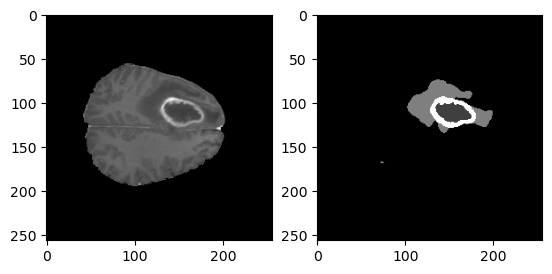

In [27]:

data = preprocess_file('/gpfs/data/luilab/karthik/brats_dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_t1ce.nii.gz')
seg_data = preprocess_file('/gpfs/data/luilab/karthik/brats_dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii.gz')

#path = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/T1.mgz'
#data_hcp = nib.load(path).get_fdata()
#data_hcp = (data_hcp / data_hcp.max() * 255).astype('uint8')

idx = 100
slice_data = data[:,idx,:]
seg_slice = seg_data[:,idx,:]
slice_data = np.repeat(slice_data[:,:,None], 3, axis = -1)
seg_slice = np.repeat(seg_slice[:,:,None], 3, axis = -1)


fig, ax = plt.subplots(1,2)

ax[0].imshow(slice_data)
ax[1].imshow(seg_slice)

219


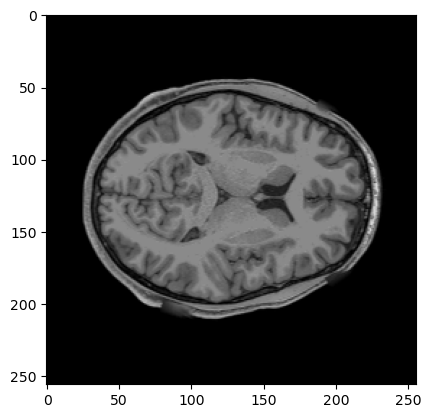

In [4]:
slice_data_hcp = data_hcp[:,140,:]
#slice_data = slice_data.astype('int')
print(slice_data_hcp.max())
slice_data_hcp = np.repeat(slice_data_hcp[:,:,None], 3, axis=-1)

plt.imshow(slice_data_hcp)

245


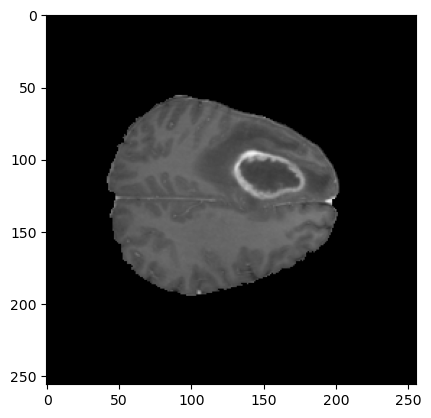

In [32]:
slice_data = data[:,100,:]



#slice_data = slice_data.astype('int')
print(slice_data.max())
slice_data = np.repeat(slice_data[:,:,None], 3, axis=-1)

plt.imshow(slice_data)



In [10]:
slice_data.shape
im = Image.fromarray(slice_data)
im.save('')

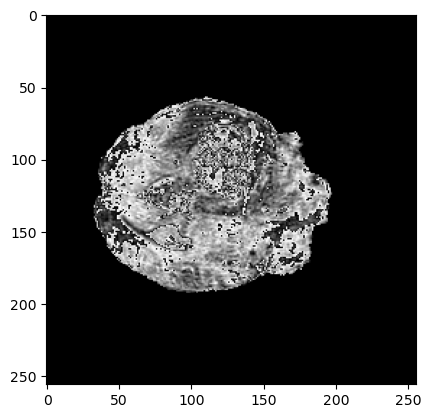

In [14]:
xx = Image.open('/gpfs/data/luilab/karthik/pediatric_seg_proj/brats_slices_npy/dir_structure_for_yolov7/train/images/001_slice140.png')
plt.imshow(xx)

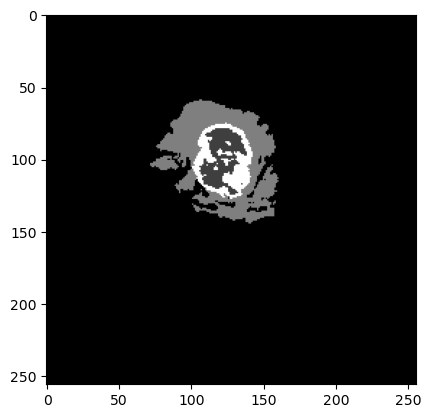

In [9]:
xx = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/brats_slices_npy/segmentation_slices/001/seg_140.npy')
xx = np.repeat(xx[:,:,None], 3, axis=-1)

plt.imshow(xx / xx.max())